# Calculating Lyapunov Exponents

In this notebook we will investigate a method for quantifying chaos in dynamical systems: Lyapunov exponents. We will numerically solve the Lorenz system, a toy example to study chaotic behaviour, and calculate its Lyapunov exponents. We will do this in two ways. First, we will define some basic functions to solve ordinary differential equations and a function to calculate a timeseries of Lyapunov exponents. This will allow us to calculate Lyapunov exponents of the Lorenz system. Second, we will replace the basic ODE solving functions by Julia's ecosystem and demonstrate how easy it is to write high level but very fast code in Julia.

I tried to provide as much help for readers not familiar with Julia, but with other high level languages, such as python, c++, java, etc. It should be possible for them to understand the content in this notebook.

This notebook's content is as follows:
 - solve the Lorenz system with a simple ODE solver
 - calculate Lyapunov timeseries utilizing the simple solvers
 - swap the simple methods for Julia packages


First of all we will activate the enviroment in the Project.toml file and instantiate it. This allows us to use exactly the packages and versions we defined there. This helps making results reproducible.

In [1]:
import Pkg
Pkg.activate(".")             # This activates the enviromnent in this folder
Pkg.instantiate()             # Downloads all the packages in the Project.toml and all dependencies in the Manifest.toml.
                              # Then builds necessary binaries.

 Activating environment at `C:\Users\Goran\MEGA\modules\HM811\projects\Julia\Project.toml`


The packages in the Project.toml can by added by executing the following cell. If we do not specify a version of the packages, the newest releases will be added.

If we wanted to update packages, we can do this with

Now that we have our packages downloaded and binaries (if the package depence on some) are build we can start using them. The first time we use a package it might need precompilation. Packages are just a collection of Julia functions (rarely some constants) and these need to be compiled when loaded. The compiled functions will be stored on the harddrive and can be loaded without compilation the next time, as long as the version of the package does not change. We first load some minimal packages and a package for plotting.

In [2]:
using Plots
using LinearAlgebra
using Random

We will overload methods from other packages right from the start to reuse code. But we have to exactly specify, which methods we want to overload - so we do not accidently overload methods we did not want or are not aware of. Julia would throw an error then. This needs to be done, outside the development of packages, rarely, but here we want to first do everything from scratch and after that use the Julia ecosystem.

In [3]:
import RecipesBase.plot
import DifferentialEquations.step!
import DifferentialEquations.solve
import DynamicalSystemsBase.get_deviations
import DynamicalSystemsBase.set_deviations!

## Solve the Lorenz systems

The Lorenz system is a system of ordinary differential equations first studied by Edward Lorenz in the 1960's. It is a "simple" system which exhibits chaotic behaviour for certain parameter and initial value combinations. It is a simple model for atmospheric convection. The ODE is given by

\begin{align}
\frac{d}{dt} x &= \sigma (y - x), \\
\frac{d}{dt} y &= x (\rho - z) - y, \\
\frac{d}{dt} z &= x y - \beta z.
\end{align}

Below we see the Julia code. It is an inplace update of the dynamical equations. The "!" is just a convention in Julia marking that the function will override its first argument(s).

In [4]:
function lorenz!(du,u,p,t)
    σ = p[1]
    ρ = p[2]
    β = p[3]

    du[1] = σ*(u[2]-u[1])
    du[2] = u[1]*(ρ-u[3])-u[2]
    du[3] = u[1]*u[2]-β*u[3]
    nothing
end

lorenz! (generic function with 1 method)

By default, functions in Julia return the result of the last statement. If we explicitly want to return nothing, we just state `nothing` at the end of the function. If we put `nothing` at the end of a cell, then we prevent any output.

We want to solve this ODE for different parameters and initial conditions. We define (very C-like) an integrator struct and a function "step!" and "solve". The function "step!" calculates the solution to the initial value problem for the next time step and the function "solve" is a convience function, which uses "step!" to compute a solution for an initial value problem.

In [5]:
mutable struct MyIntegrator
    f!                 # right hand side of ODE
    du::AbstractArray  # infinitesimal deviation cache
    u::AbstractArray   # current state
    p::AbstractArray   # additional parameters
    t::Real            # current time steps
end

my_integrator(f!, u0, p) = MyIntegrator(
        f!,               # f!
        zeros(size(u0)),  # du
        u0,               # u
        p,                # p
        0.0,              # t
    )
    

function step!(integrator::MyIntegrator, dt::Real)
    du = integrator.du
    u = integrator.u
    p = integrator.p
        
    integrator.f!(du, u, p, dt)
    u .+= dt .* du 
    integrator.t += dt
        
    nothing
end

function solve(integrator::MyIntegrator, t::Real, dt::Real)
    
    t0 = integrator.t
    t0 >= t && throw("t must be greater then integrator.t")
    ts = range(t0, t;step=dt)
    us = zeros(size(integrator.u)..., length(ts))
    us[:,1] = integrator.u    # us[:,1] denotes the 1. column of us
                              # the 1. row would be us[1,:]
    for i in 2:length(ts)
        step!(integrator, dt)
        us[:,i] = integrator.u
    end
    
    return ts, us
end
nothing

The dot syntax in `u .+= dt .* du` is a shortcut for loop fusion. The `...` syntax "unpacks" an array, e.g. `f([1,2]...)` for a function f taking two arguments is equivalent to `f(1,2)`. 

Next, we solve the Lorenz system for the initial value $x=19$, $y=20$ and $z=50$ and chose $\sigma=16$, $\rho=45.92$ and $\beta=4$. With this choice of parameters the dynamical system will have the typical attractor and the trajectory settles quickly to this attractor. One can play around with other parameters too. Two more interesting parameter triples are given later. In the rest of this notebook, we will stick to the chosen initial value and parameters. The first runtime can be comparetively long, because Julia has to compile functions the first time they are called. Run a couple of more times to see the actual runtime.

In [6]:
lorenz_solution = @time let
    u0 = [19.,20.,50.] # initial value
    p = [16.,45.92,4]  # parameters
    integrator = my_integrator(lorenz!, u0, p) # creates the integrator struct
    solve(integrator, 20., 0.01)               # solves the system
end

  0.476450 seconds (863.86 k allocations: 41.871 MiB, 5.02% gc time)


(0.0:0.01:20.0, [19.0 19.16 … 5.224589854795961 5.431639199701373; 20.0 19.0248 … 6.518648260454787 7.16871371854596; 50.0 51.8 … 32.2298930141062 31.28126992922751])

We plot the solution in 3D. This functionality is in `Plots.jl`. It may take some time for the first run.

┌ Info: Saved animation to 
│   fn = C:\Users\Goran\MEGA\modules\HM811\projects\Julia\lorenz.gif
└ @ Plots C:\Users\Goran\.julia\packages\Plots\V8QVi\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Goran\\MEGA\\modules\\HM811\\projects\\Julia\\lorenz.gif")
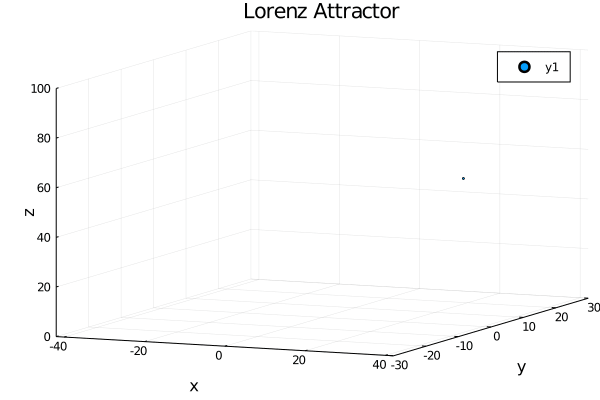

In [7]:
let
    t = lorenz_solution[1]
    u = lorenz_solution[2]
    
    # initialize a 3D plot with 1 empty series
    plt = plot3d(
        1,
        xlim = (-42, 42),
        ylim = (-30, 30),
        zlim = (0, 100),
        title = "Lorenz Attractor",
        marker = 2,
        xlabel="x",
        ylabel="y",
        zlabel="z",
    )

    # build an animated gif by pushing new points to the plot, saving every 5th frame
    anim = @animate for i=1:length(t)
        x = u[1,i]
        y = u[2,i]
        z = u[3,i]
        push!(plt, x, y, z)
        end every 5
    gif(anim, "lorenz.gif", fps = 15)
end

## Calculate Lyapunov exponents

Now that we have numerical integration and solving ordinary differential equations set up, we can focus on calculating Lyapunov exponents. We rewrite the Lorenz equations as 
\begin{align}
    \frac{d}{dt} x &= f(x, t),
\end{align}
where $x\in\mathbb{R}^3$ and
\begin{align}
    f(x_1,t) &= \sigma (x_2 - x_1), \\
    f(x_2,t) &= x (\rho - x_3) - x_2, \\
    f(x_3,t) &= x_1 x_2 - \beta x_3. 
\end{align}

The maximal Lyapunov exponent of an initial state is the exponential time dependence of the difference between the intial state and a(n) (infinitesimal) small deviation to that state. If $x$ is the initial state and $u$ is the small deviation then $\lambda$ such that
\begin{align}
    \|u(t)\| \sim e^{\lambda t} \|u(0)\|,
\end{align}
where the time evolution of $u$ is given by the ordinary differential equation, is the maximal Lyapunov exponent. The above similarity should become exact for $t\to\infty$. Mathematically rigorous this reads
\begin{align}
    \lambda = \lim_{\|u\|\to 0}\lim_{t\to\infty} \frac{1}{t} \frac{\|u(t)\|}{\|u\|}
\end{align}

Denote the solution to the above ODE for the initial value $x(0)$ at time $t$ as $\Phi(x(0),t)$. Then time evolution of $u$ is given by
\begin{align}
    \frac{\|u(t)\|}{\|u(0)\|}
    = \frac{\|x(t) + u(t) - x(t)\|}{\|u(0)\|}
    = \frac{\|\Phi(x(0) + u(0),t) - \Phi(x(0),t)\|}{\|u(0)\|}
    \to \|D_x\Phi(x(0), t) \cdot u(0)\|,
\end{align}
for $u(0)\to 0$, $D_x$ denotes the derivative with respect to the first component of $\Phi$. Now, $D_x\Phi$ is the solution of a differential equation as well as
\begin{align}
    \frac{d}{dt}D_x\Phi(x,t) 
    = D_x f(\Phi(x,t),t) 
    = (D_x f)(\Phi(x,t)) \cdot D_x\Phi(x,t),
\end{align}
the so called variational equations. To obtain the Lyapunov exponents we have to solve these variational equations, denoting $D_x\Phi(x,t) = Y$ and $D_xf=Df$,
\begin{align}
    \frac{d}{dt} x &= f(x, t) \\
    \frac{d}{dt} Y &= Df(x,t) * Y,
\end{align}
where $Df$ denotes the Jacobian matrix of $f$. We already have defined $f=$ `lorenz!` and will now define $Df=$ `lorenz_jac!`. We can not only calculate the maximal Lyapunov exponent with this method, but the whole Lyapunov spectrum. We will not go into further detail, but imagine swapping the infinitesimal deviation vector $u$ with an orthogonal matrix, representing the basis of the whole tangent space.

In [8]:
function lorenz_jac!(J,u,p,t)

    σ = p[1]
    ρ = p[2]
    β = p[3]

    J[1,1] = -σ
    J[1,2] = σ
    J[1,3] = 0
    J[2,1] = ρ-u[3]
    J[2,2] = -1
    J[2,3] = -u[1]
    J[3,1] = u[2]
    J[3,2] = u[1]
    J[3,3] = -β
    nothing
end

lorenz_jac! (generic function with 1 method)

We define the integrator struct for solving the variational equations. The `@view` makro is a short form for the `view` function, which returns non memory allocating slices of an array.

In [9]:
function my_tangent_integrator(
                f!, 
                jac!, 
                u0::Vector{<:Real},
                p::AbstractVector;
                seed::Integer=42)
    
    rng = MersenneTwister(seed)
    
    # initialize w0 with a random, orthogonal matrix
    w0 = rand(rng, length(u0), length(u0))
    w0 = Array(qr(w0).Q)
    
    # define cache for Jacobian calculation, as we are
    # calcuating in place
    J = zeros(size(w0))
    
    # this is the right hand side of the variational equations
    # the out of place version would look like
    # function tangent(u,p,t)
    #    du = f(u,p,t)
    #    J = jac(u,p,t)
    #    hcat(du, J)
    # end
    function tangent!(du,u,p,t)
        uv = @view u[:, 1]
        f!(view(du,:,1),uv ,p,t)
        jac!(J, uv,p,t)
        mul!((@view du[:, 2:end]), J, (@view u[:, 2:end]))
        nothing
    end
    
    
    u0 = hcat(u0, w0)    # hcat concatenates columnwise
    integ = my_integrator(tangent!, u0, p)

    return integ
end


my_tangent_integrator (generic function with 1 method)

We define some convenience functions to get and set the tangent space spanning $Y$. We want a setter function as well, as we will renormalize $Y$ while solving the variational equations to prevent numerical overflow due to exponential growth of the entries of $Y$, if the corresponding dynamical system is chaotic.

In [10]:
get_deviations(integ) = @view integ.u[:, 2:end]
set_deviations!(integ, Q)  = (integ.u[:, 2:end] .= Q)

set_deviations! (generic function with 5 methods)

Now we will define the most important function - the function calculating a timeseries of Lyapunov exponents. The timeseries allows us later to visually observe sufficient convergence. This function was used (slightly modified) in one of my projects on chaos in classical systems.

In [11]:
struct LyapunovExponentSolution
    t::AbstractArray
    u::AbstractArray
    lyapunov::AbstractArray
end

LSE = LyapunovExponentSolution

"""
    Calculates time series Lyapunov exponents.
    t_max is the maximum time 
    dt is the stepsize, not necessarily of the integrator,
    but 
"""
function lyap_qr_time_series(integ, t_max::Real, dt::Real; 
        t_pre_iter::Real=0, 
        t_save::Real=dt,
        t_renormalize::Real=dt,
        lyapunov_count::Integer=1
    )

    @assert length(integ.u) >= lyapunov_count "Can not calculate more Lyapunov exponents than the systems dimension: $dim"

    last_t_renormalized = integ.t

    # Pre iterate the system
    while integ.t < t_pre_iter
        # as long as we do not have to renormalize, we do not do it
        if integ.t - last_t_renormalized < t_renormalize
            step!(integ)
        else
            _lyap_step_qr!(integ, dt)
            last_t_renormalized = integ.t
        end
    end

    
    t0 = integ.t
    ts = range(t0+dt; stop=t_max, step=t_save)    # timesteps
    us = zeros(size(integ.u[:,1])..., length(ts)) # solution of the system at the corresponding timesteps
    lyapunovs = zeros(lyapunov_count, length(ts)) # Lyapunov exponents at the corresponding timesteps
    lyap_tmp = zeros(lyapunov_count)              # cache
     
    for i in 1:length(ts)
        # we integrate the system up to the next saving time
        while integ.t < ts[i]
            # as long as we do not have to renormalize, we do not do it
            if integ.t - last_t_renormalized < t_renormalize
                step!(integ, dt)
            else
                R = _lyap_step_qr!(integ, dt)
                
                # we accumulate the exponential growth of the deviation vectors
                for j in 1:lyapunov_count
                    lyap_tmp[j] += log(abs(R[j,j]))
                end
                last_t_renormalized = integ.t
            end
        end
        
        # save the systems state and the calculated Lyapunov exponents
        us[:,i] = integ.u[:,1]
        lyapunovs[:,i] = lyap_tmp ./ (integ.t-t0)
    end
    
    lse = LyapunovExponentSolution(
        ts,
        us,
        lyapunovs
    )
    
    return lse
end

"""
    Evolves the system for dt time and renormalizes the tangent space.
"""
function _lyap_step_qr!(integ, dt)
    # Evolve the the coupled system and get the tangent vectors
    step!(integ, dt)
    w = get_deviations(integ)

    # Orthonormalize the tangent vectors
    F = qr(w)
    w = Matrix(F.Q)

    # Reinitialize the tangent vectors with the normalized ones
    set_deviations!(integ, w)

    return Matrix(F.R)
end



_lyap_step_qr!

Now, everything comes together and we can use our ODE solvers, the tangent integrator and our Lyapunov exponent timeseries function to calculate the timeseries of Lyapunov exponents. Again, the first time the following code block is run, function compilation will dominate the runtime. Run the cell multiple times to time the calculation takes without compilation.

In [12]:
lse = @time let
    u0 = [19.,20.,50.]
    p = [16.,45.92,4]
    integrator = my_tangent_integrator(lorenz!, lorenz_jac!, u0, p)

    dt = 0.001
    t_max = 10
    lyap_qr_time_series(integrator, t_max, dt; 
        t_pre_iter=0, 
        t_save=t_max/100,
        t_renormalize=10*dt,
        lyapunov_count=length(u0)
    )
end

  1.673564 seconds (5.68 M allocations: 255.904 MiB, 4.25% gc time)


LyapunovExponentSolution(0.001:0.1:9.901, [19.016 12.385696823686619 … -5.2518935240543865 -13.568795691641062; 19.90248 6.108653322257634 … -8.316908035896379 -21.370269038780975; 50.18 50.92691479969765 … 30.759860771841222 31.965483563562383], [0.0 -1.6447966930995148 … 1.5454928523475424 1.5243791843778287; 0.0 -13.016800340076676 … -0.23589821590404067 -0.16585816793391753; 0.0 -5.657290703962748 … -22.364476289427312 -22.405526685764357])

At the beginning of the notebook we imported from RecipesBase the plot method. We did this so we can define a plotting function for the `LyapunovExponentSolution` struct, besides there being multiple `plot` methods defined in `Plots` already. Multiple dispatch is one of Julia's most characterizing design choices.

The first time we call the `plot` method, it shows how many methods with the same name are defined.

In [13]:
plot

plot (generic function with 3 methods)

In [14]:
function plot(lse::LyapunovExponentSolution, args...;kwargs...)
    plot(lse.t, transpose(lse.lyapunov), args...;kwargs...)
    plot!(
        xlabel="time",
        ylabel="Lyapunov exponent",
    )
end

plot (generic function with 4 methods)

The next time we call `plot` the number of methods should have increased by one.

In [15]:
plot

plot (generic function with 4 methods)

In the plot below we see the calculated Lyapunov exponent for increasing time the system is evolved. The longer one integrates the variational equations the better the estimate for the Lyapunov exponents should become. The actual Lyapunov exponents of the Lorenz system are, with an error of $0.00008$:
 - $\approx 1.50255$
 - 0
 - $\approx -22.50255$
 
Altough we only used a (non-symplectic) first order method to integrate the system and the tangent space, we obtain surprisingly good convergence.

For other parameter choices
\begin{align}
    \sigma &= 16 \\
    \rho &= 40 \\
    \beta &= 4
\end{align}
and
\begin{align}
    \sigma &= 10 \\
    \rho &= 28 \\
    \beta &= 8/3
\end{align}
the actual Lyapunov exponents are with an error of $0.0006$
 - $\approx 1.37446$
 - 0 
 - $\approx -22.37446$
 
and with an error of $0.00007$
 - $\approx 0.90566$ 
 - 0
 - $\approx -14.57233$


lse.lyapunov[:, end] = [1.5243791843778287, -0.16585816793391753, -22.405526685764357]


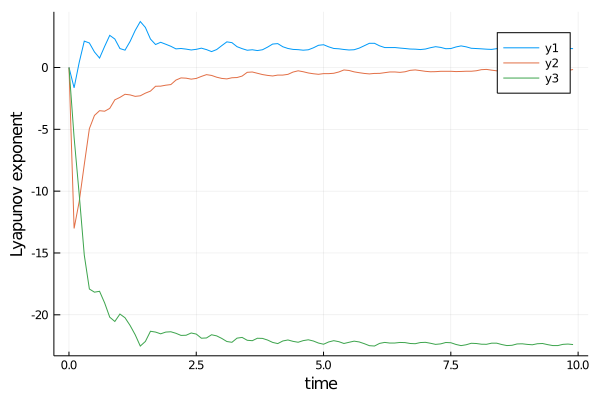

In [16]:
@show lse.lyapunov[:,end]
plot(lse)

The next cell wraps the calculation of the Lyapunov exponents and the plotting. We encourage the reader to play around with the parameters and see how the result changes.

lse.lyapunov[:, end] = [1.8118244751558523, -0.13685467926037476, -22.750828809973147]
  0.092361 seconds (644.74 k allocations: 24.350 MiB)


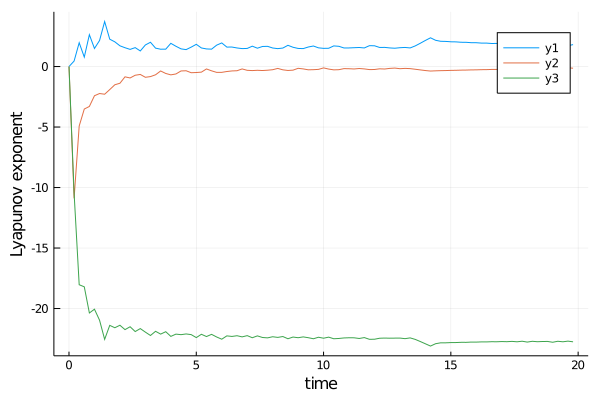

In [17]:
@time let
    u0 = [19.,20.,50.]
    p = [16.,45.92,4]
    integrator = my_tangent_integrator(lorenz!, lorenz_jac!, u0, p)

    dt = 0.001
    t_max = 20
    lse = lyap_qr_time_series(integrator, t_max, dt; 
        t_pre_iter=0, 
        t_save=t_max/100,
        t_renormalize=1*dt,
        lyapunov_count=length(u0)
    )
    
    @show lse.lyapunov[:,end]
    plot(lse)
end

# Using the Julia Ecosystem



In this section we will exchange our very simple ODE integration functions with highly optimized Julia packages. 

In [18]:
using DifferentialEquations     # this might take some time to load (or precompile)
using DynamicalSystems

using DynamicalSystemsBase:_tannorm

Following, we will reuse the code for calculating the Lyapunov timeseries, defining the variational equation update method as in the `tangent_integrator` function, but now using the functions `ODEProblem` and `init` to define the integrator, which we can use in `lyap_qr_time_series`. Again, we recommend playing around with the parameters. Other integration methods can be found at https://docs.sciml.ai/stable/solvers/ode_solve/. 

lse.lyapunov[:, end] = [1.516068733717005, -0.013307037334181086, -22.488264328781014]
  5.633398 seconds (16.62 M allocations: 796.315 MiB, 4.59% gc time)


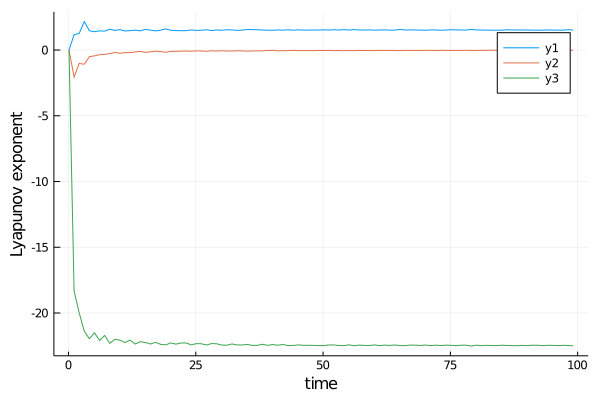

In [19]:
@time let
    u0 = [19.,20.,50.]
    p = [16.,45.92,4]
    
    # the setup is the same as in the tangent integrator we defined before
    rng = MersenneTwister(42)
    w0 = rand(rng, length(u0), length(u0))
    w0 = Array(qr(w0).Q)
    
    f! = lorenz!
    jac! = lorenz_jac!
    
    J = zeros(size(w0))
    
    function F!(du,u,p,t)
        uv = @view u[:, 1]
        f!(view(du,:,1),uv ,p,t)
        jac!(J, uv,p,t)
        mul!((@view du[:, 2:end]), J, (@view u[:, 2:end]))
    end
    
    # define and initial value problem of the variational equations
    # with initial value hcat(u0, w0) and the parameters p.
    # (0, Inf) sets the time span.
    ode_problem = ODEProblem(F!, hcat(u0, w0), (0., Inf), p)
    
    # define the integrator object similar to what we implemented earlier
    #
    # Tsit5 is an adaptive 5/4 Runge-Kutta method with efficient interpolation
    # between timesteps.
    #
    # The estimated error just needs to be calculated for the solution of the actual
    # system, not the tangent space
    integrator = init(ode_problem, Tsit5(); norm=_tannorm, save_everystep = false)

    dt = 0.1
    t_max = 100
    lse = lyap_qr_time_series(integrator, t_max, dt; 
        t_pre_iter=0, 
        t_save=t_max/100,
        t_renormalize=dt,
        lyapunov_count=length(u0)
    )
    
    @show lse.lyapunov[:,end]
    plot(lse)
end

### Utilizing symbolic and auto-differentiation

Once we defined an ordinary differential equation $\frac{d}{dt}x=f(x,t)$, its tangent space $Df$ is defined as well. So, if we could teach our program how to differentiate, there would be no need to define the Jacobian by hand. 

Additionally, imagine that our ODE is stiff. Then we need implicit methods to efficiently solve it (for a long time). Most stiff methods require access to the Jacobian of the variational equations. Let us think about defining the Jacobian of the Lorenz system by hand. The Lorenz system is 3-dimension, so its Jacobian is 9-dimensional and hence the variational equations are 9-dimension as well. The Jacobian of the variational equations now has 9x9=81 dimensions. So the Jacobian of the variational equations of a 3-dimensional system is already 81-dimensional. We really, do not want define this by hand, especially for higher dimensional systems.

Luckily, nearly all of Julias numerical functions are compatible with auto-differentiation. Try to change the explicit algorithm `Tsit5()` to an implicit one, e.g. `Rosenbrock23()`. The solver tries to auto-differentiate the code
```
J = zeros(size(w0))
    
function F!(du,u,p,t)
    uv = @view u[:, 1]
    f!(view(du,:,1),uv ,p,t)
    jac!(J, uv,p,t)
    mul!((@view du[:, 2:end]), J, (@view u[:, 2:end]))
end
```
But it will fail because the cache `J`, as we implemented it, is not compatible with dual numbers, the underlying mathematical framework of auto-differention. We could do the following:
 - calculate the Jacobian with auto-differentiation and make the cache compatible with dual numbers
 - calculate the Jacobian and the Jacobian of the variational equations symbolically

We will choose the second approach as it is less technical and more flexible.

In [20]:
using ModelingToolkit

First we define the right hand side of the Lorenz system symbolically in the language of `ModelingTolkit`.

In [21]:
# define parameters used in our ODE
@parameters t 
@parameters σ ρ β

# define our variables
@variables x[1:3](t)

# define the time derivative
@derivatives dt'~t

lorenz = [
        σ*(x[2]-x[1]),
        x[1]*(ρ-x[3])-x[2],
        x[1]*x[2] - β*x[3]
    ]

3-element Array{Operation,1}:
         σ * (x₂(t) - x₁(t))
 x₁(t) * (ρ - x₃(t)) - x₂(t)
   x₁(t) * x₂(t) - β * x₃(t)

Then we symbolically calculate the Jacobian of the Lorenz system.

In [22]:
# define the variables
@variables w[1:3,1:3](t)
lorenz_jac = expand_derivatives.(calculate_jacobian(lorenz, x))

3×3 Array{Expression,2}:
            -1σ             σ  Constant(0)
 -1 * x₃(t) + ρ  Constant(-1)   -1 * x₁(t)
          x₂(t)         x₁(t)          -1β

We can check that the symbolically calculated Jacobian of the Lorenz system is indeed coincides with the one we defined at the beginning of this notebook by hand.

In [23]:
# TODO

Now we define the right hand side of the variational equations 

In [24]:
lorenz_tangent = let
    # define the tangent system, i.e. Leorentz system + its jacobian
    # This is the rhs we want to evolve
    vcat(lorenz..., lorenz_jac*w...) # note the *w
end

12-element Array{Operation,1}:
                                             σ * (x₂(t) + -1 * x₁(t))
                                     x₁(t) * (-1 * x₃(t) + ρ) - x₂(t)
                                            x₁(t) * x₂(t) - x₃(t) * β
                        ((-1σ) * w₁ˏ₁(t) + σ * w₂ˏ₁(t)) + 0 * w₃ˏ₁(t)
 ((-1 * x₃(t) + ρ) * w₁ˏ₁(t) + -1 * w₂ˏ₁(t)) + (-1 * x₁(t)) * w₃ˏ₁(t)
                (x₂(t) * w₁ˏ₁(t) + x₁(t) * w₂ˏ₁(t)) + (-1β) * w₃ˏ₁(t)
                        ((-1σ) * w₁ˏ₂(t) + σ * w₂ˏ₂(t)) + 0 * w₃ˏ₂(t)
 ((-1 * x₃(t) + ρ) * w₁ˏ₂(t) + -1 * w₂ˏ₂(t)) + (-1 * x₁(t)) * w₃ˏ₂(t)
                (x₂(t) * w₁ˏ₂(t) + x₁(t) * w₂ˏ₂(t)) + (-1β) * w₃ˏ₂(t)
                        ((-1σ) * w₁ˏ₃(t) + σ * w₂ˏ₃(t)) + 0 * w₃ˏ₃(t)
 ((-1 * x₃(t) + ρ) * w₁ˏ₃(t) + -1 * w₂ˏ₃(t)) + (-1 * x₁(t)) * w₃ˏ₃(t)
                (x₂(t) * w₁ˏ₃(t) + x₁(t) * w₂ˏ₃(t)) + (-1β) * w₃ˏ₃(t)

and define the variational equations

In [25]:
y = vcat(x..., w...)
@assert length(y) == length(lorenz_tangent)

variational_equations = Equation[]
for i in 1:length(y)
    push!(variational_equations, dt(y[i]) ~ lorenz_tangent[i])
end
variational_equations

12-element Array{Equation,1}:
 Equation(derivative(x₁(t), t), σ * (x₂(t) + -1 * x₁(t)))
 Equation(derivative(x₂(t), t), x₁(t) * (-1 * x₃(t) + ρ) - x₂(t))
 Equation(derivative(x₃(t), t), x₁(t) * x₂(t) - x₃(t) * β)
 Equation(derivative(w₁ˏ₁(t), t), ((-1σ) * w₁ˏ₁(t) + σ * w₂ˏ₁(t)) + 0 * w₃ˏ₁(t))
 Equation(derivative(w₂ˏ₁(t), t), ((-1 * x₃(t) + ρ) * w₁ˏ₁(t) + -1 * w₂ˏ₁(t)) + (-1 * x₁(t)) * w₃ˏ₁(t))
 Equation(derivative(w₃ˏ₁(t), t), (x₂(t) * w₁ˏ₁(t) + x₁(t) * w₂ˏ₁(t)) + (-1β) * w₃ˏ₁(t))
 Equation(derivative(w₁ˏ₂(t), t), ((-1σ) * w₁ˏ₂(t) + σ * w₂ˏ₂(t)) + 0 * w₃ˏ₂(t))
 Equation(derivative(w₂ˏ₂(t), t), ((-1 * x₃(t) + ρ) * w₁ˏ₂(t) + -1 * w₂ˏ₂(t)) + (-1 * x₁(t)) * w₃ˏ₂(t))
 Equation(derivative(w₃ˏ₂(t), t), (x₂(t) * w₁ˏ₂(t) + x₁(t) * w₂ˏ₂(t)) + (-1β) * w₃ˏ₂(t))
 Equation(derivative(w₁ˏ₃(t), t), ((-1σ) * w₁ˏ₃(t) + σ * w₂ˏ₃(t)) + 0 * w₃ˏ₃(t))
 Equation(derivative(w₂ˏ₃(t), t), ((-1 * x₃(t) + ρ) * w₁ˏ₃(t) + -1 * w₂ˏ₃(t)) + (-1 * x₁(t)) * w₃ˏ₃(t))
 Equation(derivative(w₃ˏ₃(t), t), (x₂(t) * w₁ˏ₃(t) + x

Next, we define our initial values and parameters as before. Then we need to compile the variational equations into Julia functions and define the corresponding `ODEProblem`. Then we proceed as before to define the integrator object.

In [26]:
@time modeling_toolkit_integrator = let
    u0 = [19.,20.,50.]
    p = [16.,45.92,4]
    
    # the setup is the same as in the tangent integrator we defined before
    rng = MersenneTwister(42)
    w0 = rand(rng, length(u0), length(u0))
    w0 = Array(qr(w0).Q)
    
    # define an ODESystem and an ODEFunction
    ode_system = ODESystem(variational_equations)
    ode_function = ODEFunction(ode_system, y, [σ, ρ, β]; jac=true)

    # define the ODEProblem with parameters
    ode_problem = ODEProblem(ode_function, hcat(u0, w0), (0., Inf), p)
    
    # create the integrator
    integrator = init(ode_problem, Rosenbrock23(); norm=_tannorm, save_everystep = false) 
    
end

 17.206971 seconds (31.65 M allocations: 1.549 GiB, 2.51% gc time)


t: 0.0
u: 3×4 Array{Float64,2}:
 19.0  -0.761116    0.368551   0.533734
 20.0  -0.648124   -0.400116  -0.647952
 50.0  -0.0252479  -0.839093   0.543402

By setting `jac=false` in the `ODEFunction` call, the Jacobian of the variational system would be calculated via auto-differentiation, if the solver algorithm relies on it. This is possible because the cache handling is now done by `ODEFunction`, which is compatible with dual numbers.

Now we have our integrator object and can finally call the function calculating the Lyapunov timeseries.  

lse.lyapunov[:, end] = [1.4880146206090141, -0.22626019769684472, -22.124219328828115]
  1.966174 seconds (830.21 k allocations: 36.124 MiB)


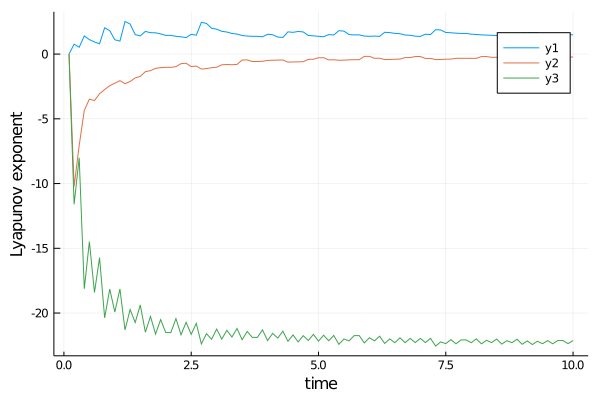

In [27]:
@time let
    
    dt = 0.1
    t_max = 10
    lse = lyap_qr_time_series(modeling_toolkit_integrator, t_max, dt; 
        t_pre_iter=0, 
        t_save=t_max/100,
        t_renormalize=dt,
        lyapunov_count=3
    )
    
    @show lse.lyapunov[:,end]
    plot(lse)
end